<a href="https://colab.research.google.com/github/dinarsadykow/kaggle/blob/main/TabularPlaygroundSeries_Nov2022.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ❄️ TPS-NOV2022 Fast AI Model.
https://www.kaggle.com/code/cv13j0/tps-nov2022-fast-ai-model

### Overview
In this Notebook I try a simple implementation of a **Neuronal Network** using the **Fast AI** library...
Interms of the dataset we are provide with multiple prediction files and true labels, approximathly 40,000 rows of data per prediction file and approximathly 4000 files, and true labels for half of it or 20,000 records.
Basicaly we need to ensamble this predictions in a way to maximize the model performance, let's start simple with a Logiegression Model, below the steps I will follow.

<img src='https://www.novetta.com/wp-content/uploads/2021/02/fastai-1.png' width = 550>

### Steps
* Load all the data into 1 Dataframe, Remove Files with Logloss higher than 0.68
* Explore the information loaded
* Create a train and a validation dataset
* Training a simple LR model using **fast.ai**
* Upload submission to the LB for the best model

### Dataset Description
In this competition, you are given a folder of submissions that contain predictions for a binary classification task. The ground truth for these rows are provided in the file train_labels.csv. Each file name in the submissions folder corresponds to the logloss score of the the first half of the prediction rows against the ground truth labels in that file. This is effectively the "training" set.

Your task is to use blend (ensemble) the various submission files to produce better model predictions. You can tell if the blend produces better results because you have the ground truth labels for the first half of the rows. In other words, you can blend two files together, check the score on the first half of the rows, and the score improves, you can submit the results from the rest of the rows to the leaderboard.

A simple example is shown in this notebook.

### Files
* submission_files/ - a folder containing binary model predictions
* train_labels.csv - the ground truth labels for the first half of the rows in the submission files
* sample_submission.csv - a sample submission file in the correct format, only containing the row ids for the second half of each file in the submissions folder; your task is to blend together submissions that achieve the improvements in the score.


# Data Load

## 1.0 Installing Requiered Libraries...

In [1]:
%%capture
# Upgrade the fastai libraries, to use the latest updates.

!pip3 install --upgrade fastai

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%%capture

# ------------------------------------------------------
# Kaggle Download Data

import json

!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json

# api_token = {"username":"123","key":"456"}
api_token = json.load( open('/content/drive/MyDrive/kaggle.json','r') )

with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 ~/.kaggle/kaggle.json

# !kaggle competitions download -c otto-recommender-system
# !unzip /content/otto-recommender-system.zip

!kaggle competitions download -c tabular-playground-series-nov-2022
!unzip /content/tabular-playground-series-nov-2022.zip


---

## 2.0 Loading Libraries...

In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
row = 0
for dirname, _, filenames in os.walk('/content/submission_files'):
    for filename in filenames:
        row += 1
        if row > 10: 
            break
        # print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [5]:
%%time
# Load the fastai tabular modules.

import fastai; fastai.__version__
from fastai.tabular.all import *

CPU times: user 957 ms, sys: 188 ms, total: 1.14 s
Wall time: 2.6 s


---

## 3.0 Configuring the Notebook Properties...

In [6]:
%%time
# I like to disable my Notebook Warnings.
import warnings
warnings.filterwarnings('ignore')

CPU times: user 31 µs, sys: 6 µs, total: 37 µs
Wall time: 39.1 µs


In [7]:
%%time
# Notebook Configuration.

# Amount of data we want to load into the Model.
DATA_ROWS = None
# Dataframe, the amount of rows and cols to visualize.
NROWS = 25
NCOLS = 15
# Main data location path...
BASE_PATH = '...'

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 5.01 µs


In [8]:
%%time
# Configure notebook display settings to only use 2 decimal places, tables look nicer.

pd.options.display.float_format = '{:,.5f}'.format
pd.set_option('display.max_columns', NCOLS) 
pd.set_option('display.max_rows', NROWS)

CPU times: user 53 µs, sys: 9 µs, total: 62 µs
Wall time: 63.9 µs


---

## 4.0 Loading the Information

In [9]:
%%time
labels = pd.read_csv('/content/train_labels.csv')

CPU times: user 5.33 ms, sys: 5.3 ms, total: 10.6 ms
Wall time: 11.2 ms


In [10]:
%%time
prediction_sample = pd.read_csv('/content/submission_files/0.7301891713.csv')

CPU times: user 9.31 ms, sys: 6.13 ms, total: 15.4 ms
Wall time: 15.7 ms


In [11]:
%%time
submission = pd.read_csv('/content/sample_submission.csv')

CPU times: user 4.62 ms, sys: 4.11 ms, total: 8.73 ms
Wall time: 10 ms


In [12]:
%%time
logloss_limit = 0.68
features = pd.DataFrame() 
features['id'] = prediction_sample['id']
for dirname, _, filenames in os.walk('/content/submission_files'):
    for ix, filename in enumerate(filenames):
        logloss_value = float(filename[:12])
        if logloss_value <= logloss_limit:
            tmp = pd.read_csv(os.path.join(dirname, filename))
            features['pred_' + str(logloss_value)] = tmp['pred']

CPU times: user 4.61 s, sys: 369 ms, total: 4.98 s
Wall time: 4.98 s


In [13]:
features

,id,pred_0.637546764,pred_0.6407502338,pred_0.67673163,pred_0.6728522772,pred_0.6657081871,pred_0.6681247548,...,pred_0.6781816029,pred_0.667147642,pred_0.651807947,pred_0.6783986799,pred_0.6715751257,pred_0.6684406999,pred_0.6603869261
0,0,0.65209,0.84521,0.76163,0.93815,0.81314,0.82639,...,0.81874,0.83500,0.90268,0.70115,0.63948,0.73663,0.86599
1,1,0.57177,0.67018,0.60156,0.60837,0.70829,0.65735,...,0.63052,0.74562,0.62417,0.61092,0.49135,0.70260,0.56080
2,2,0.75562,0.73088,0.83406,0.83291,0.78056,0.79914,...,0.83148,0.82219,0.82345,0.79078,0.66534,0.81407,0.82900
3,3,0.62584,0.70107,0.81463,0.78546,0.75773,0.76233,...,0.79702,0.88514,0.79864,0.70666,0.60301,0.74393,0.82974
4,4,0.88801,0.84830,0.95744,0.95721,0.98001,0.95163,...,0.95833,0.96250,0.96480,0.92331,0.72290,0.94967,0.96109
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,39995,0.24690,0.48668,0.53523,0.49080,0.50954,0.48129,...,0.50976,0.50592,0.44007,0.51505,0.35340,0.51535,0.50169
39996,39996,0.50012,0.58006,0.60515,0.59339,0.60662,0.65109,...,0.55830,0.69300,0.60373,0.55995,0.44917,0.54599,0.56348
39997,39997,0.60453,0.77187,0.79828,0.73916,0.73777,0.77322,...,0.78691,0.85330,0.75094,0.71140,0.55725,0.70356,0.77011
39998,39998,0.89645,0.72035,0.66345,0.72160,0.67225,0.73228,...,0.74909,0.59818,0.70731,0.77080,0.69289,0.78230,0.79614


In [14]:
%%time
train_df = features.loc[:19999].copy(deep = True)
train_df['label'] = labels['label']

CPU times: user 38.9 ms, sys: 87.9 ms, total: 127 ms
Wall time: 128 ms


In [15]:
train_df.reset_index(inplace=True, drop = True)

In [16]:
%%time
test_df = features.iloc[20000:].copy(deep = True)
test_df.reset_index(inplace=True, drop = True)

CPU times: user 69.6 ms, sys: 22.3 ms, total: 91.9 ms
Wall time: 93.9 ms


In [17]:
train_df.head()

,id,pred_0.637546764,pred_0.6407502338,pred_0.67673163,pred_0.6728522772,pred_0.6657081871,pred_0.6681247548,...,pred_0.667147642,pred_0.651807947,pred_0.6783986799,pred_0.6715751257,pred_0.6684406999,pred_0.6603869261,label
0,0,0.65209,0.84521,0.76163,0.93815,0.81314,0.82639,...,0.83500,0.90268,0.70115,0.63948,0.73663,0.86599,0
1,1,0.57177,0.67018,0.60156,0.60837,0.70829,0.65735,...,0.74562,0.62417,0.61092,0.49135,0.70260,0.56080,1
2,2,0.75562,0.73088,0.83406,0.83291,0.78056,0.79914,...,0.82219,0.82345,0.79078,0.66534,0.81407,0.82900,1
3,3,0.62584,0.70107,0.81463,0.78546,0.75773,0.76233,...,0.88514,0.79864,0.70666,0.60301,0.74393,0.82974,1
4,4,0.88801,0.84830,0.95744,0.95721,0.98001,0.95163,...,0.96250,0.96480,0.92331,0.72290,0.94967,0.96109,0


In [18]:
test_df.head()

,id,pred_0.637546764,pred_0.6407502338,pred_0.67673163,pred_0.6728522772,pred_0.6657081871,pred_0.6681247548,...,pred_0.6781816029,pred_0.667147642,pred_0.651807947,pred_0.6783986799,pred_0.6715751257,pred_0.6684406999,pred_0.6603869261
0,20000,0.80069,0.78789,0.85338,0.83271,0.81845,0.73435,...,0.83813,0.87658,0.83026,0.76727,0.68038,0.84066,0.83521
1,20001,0.82787,0.71572,0.76825,0.84008,0.78606,0.74940,...,0.79664,0.72550,0.86067,0.73814,0.63948,0.73437,0.87645
2,20002,0.20277,0.42151,0.57007,0.48470,0.63448,0.62808,...,0.56923,0.57583,0.43640,0.60072,0.65628,0.57604,0.51460
3,20003,0.34985,0.62367,0.62322,0.66366,0.58592,0.65402,...,0.63017,0.56000,0.63085,0.65746,0.60613,0.63935,0.49498
4,20004,0.21713,0.20813,0.75741,0.84509,0.46285,0.64723,...,0.70628,0.32050,0.17916,0.58148,0.60667,0.61222,0.44147


---

## 5.0 Pre-Processing the Data

In [19]:
%%time
# Create a list to be used as features
continuous_feat = [feat for feat in train_df.columns if feat not in ['id', 'label']]

CPU times: user 167 µs, sys: 22 µs, total: 189 µs
Wall time: 197 µs


In [20]:
%%time
# Create correlation matrix
corr_matrix = train_df[continuous_feat].corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find features with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.98)]

# Drop features 
train_df.drop(to_drop, axis=1, inplace=True)

CPU times: user 18.5 s, sys: 43.6 ms, total: 18.6 s
Wall time: 18.5 s


In [21]:
%%time 
# Updates the features after high correlation features have been removed
continuous_feat = [feat for feat in train_df.columns if feat not in ['id', 'label'] + to_drop]

CPU times: user 2.36 ms, sys: 0 ns, total: 2.36 ms
Wall time: 2.44 ms


In [22]:
%%time 
# Clip the datasets between 0 and 1
print('Min Value:', train_df[continuous_feat].min().min())
print('Max Value:', train_df[continuous_feat].max().max())
print('....', '\n')

train_df = train_df.clip(0,1) # Clip the dataframe values...

# Check the results of the Clipping...
print('Min Value:', train_df[continuous_feat].min().min())
print('Max Value:', train_df[continuous_feat].max().max())
print('\n')


Min Value: -0.147299
Max Value: 1.276571
.... 

Min Value: 0.0
Max Value: 1.0


CPU times: user 218 ms, sys: 2.01 ms, total: 220 ms
Wall time: 186 ms


In [23]:
%%time 
# Display some of the info
train_df[continuous_feat].info(verbose = False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Columns: 294 entries, pred_0.637546764 to pred_0.6684406999
dtypes: float64(294)
memory usage: 44.9 MB
CPU times: user 31 ms, sys: 73 µs, total: 31.1 ms
Wall time: 35.7 ms


In [24]:
train_df

,id,pred_0.637546764,pred_0.6407502338,pred_0.67673163,pred_0.6728522772,pred_0.6657081871,pred_0.6681247548,...,pred_0.6737624943,pred_0.6725729469,pred_0.6744120938,pred_0.6783986799,pred_0.6715751257,pred_0.6684406999,label
0,0,0.65209,0.84521,0.76163,0.93815,0.81314,0.82639,...,0.72790,0.75000,0.83429,0.70115,0.63948,0.73663,0
1,1,0.57177,0.67018,0.60156,0.60837,0.70829,0.65735,...,0.60591,0.56000,0.58945,0.61092,0.49135,0.70260,1
2,1,0.75562,0.73088,0.83406,0.83291,0.78056,0.79914,...,0.78115,0.69000,0.79908,0.79078,0.66534,0.81407,1
3,1,0.62584,0.70107,0.81463,0.78546,0.75773,0.76233,...,0.73582,0.66000,0.78031,0.70666,0.60301,0.74393,1
4,1,0.88801,0.84830,0.95744,0.95721,0.98001,0.95163,...,0.88366,0.70000,0.96694,0.92331,0.72290,0.94967,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,1,0.97335,0.85395,0.93431,0.88151,0.90797,0.92293,...,0.82097,0.76000,0.90322,0.89384,0.70876,0.91404,1
19996,1,0.61399,0.65917,0.67888,0.56321,0.67229,0.62687,...,0.71243,0.61000,0.65189,0.69134,0.57189,0.54787,1
19997,1,0.71438,0.83152,0.91279,0.92202,0.96831,0.91295,...,0.86766,0.72000,0.92789,0.88081,0.65102,0.93091,0
19998,1,0.66426,0.75823,0.63282,0.68486,0.79368,0.71899,...,0.70672,0.69000,0.66357,0.68680,0.64184,0.68127,0


In [25]:
test_df = test_df[[x for x in train_df.columns if x not in ['label']]]
test_df

,id,pred_0.637546764,pred_0.6407502338,pred_0.67673163,pred_0.6728522772,pred_0.6657081871,pred_0.6681247548,...,pred_0.6665122792,pred_0.6737624943,pred_0.6725729469,pred_0.6744120938,pred_0.6783986799,pred_0.6715751257,pred_0.6684406999
0,20000,0.80069,0.78789,0.85338,0.83271,0.81845,0.73435,...,0.84437,0.76805,0.72000,0.82914,0.76727,0.68038,0.84066
1,20001,0.82787,0.71572,0.76825,0.84008,0.78606,0.74940,...,0.82712,0.76429,0.55000,0.77852,0.73814,0.63948,0.73437
2,20002,0.20277,0.42151,0.57007,0.48470,0.63448,0.62808,...,0.59924,0.58131,0.60000,0.68682,0.60072,0.65628,0.57604
3,20003,0.34985,0.62367,0.62322,0.66366,0.58592,0.65402,...,0.71919,0.63661,0.65000,0.69044,0.65746,0.60613,0.63935
4,20004,0.21713,0.20813,0.75741,0.84509,0.46285,0.64723,...,0.47470,0.58371,0.72000,0.58109,0.58148,0.60667,0.61222
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,39995,0.24690,0.48668,0.53523,0.49080,0.50954,0.48129,...,0.47039,0.49752,0.52000,0.45287,0.51505,0.35340,0.51535
19996,39996,0.50012,0.58006,0.60515,0.59339,0.60662,0.65109,...,0.64281,0.51155,0.49000,0.60270,0.55995,0.44917,0.54599
19997,39997,0.60453,0.77187,0.79828,0.73916,0.73777,0.77322,...,0.75343,0.65865,0.64000,0.70588,0.71140,0.55725,0.70356
19998,39998,0.89645,0.72035,0.66345,0.72160,0.67225,0.73228,...,0.79895,0.68925,0.66000,0.72950,0.77080,0.69289,0.78230


# Fast AI metod

In [26]:
!kaggle kernels output cv13j0/tps-nov2022-fast-ai-model -p /content/

Output file downloaded to /content/submission_fastai.csv
Kernel log downloaded to /content/tps-nov2022-fast-ai-model.log 


In [27]:
%%time
# Creating a list of the data preprocessing steps we want to apply to the model...

data_processing = [
                    FillMissing, # Fill the missing values in continuous columns.
                    Normalize,
                  ]

CPU times: user 5 µs, sys: 1 µs, total: 6 µs
Wall time: 12.9 µs


In [28]:
data_processing

[fastai.tabular.core.FillMissing, fastai.data.transforms.Normalize]

In [29]:
%%time
# Create a dataloader to be used by the learner
# Difining some data loader params

batch_size = 1024
valid_pct  = 0.1

# Creting the tabular data loader
data = TabularDataLoaders.from_df(df = train_df,               # Here we pass tge train dataset.
                                  path = '.',                  # Here we pass the location path of the data, in this case null = '.'
                                  procs = data_processing,     # Apply selected transformations to the data
                                  cat_names = None,            # Specify categorical features
                                  cont_names = continuous_feat,# Specify numerical features
                                  valid_pct = valid_pct,       # Set the percentage of the dataset to be used in the validation process
                                  bs = batch_size,             # Specify the batch size
                                  y_block = CategoryBlock,     # Specify the type of target variable
                                  y_names = 'label',           # Specify the name of the target variable for the model
                                  shuffle_train = True,         # Specify if the dataset should be shuffle
                                 )

CPU times: user 312 ms, sys: 56.5 ms, total: 369 ms
Wall time: 437 ms


In [30]:
%%time
# Display a batch of the data loaded to the data loader that will be used in the training stage
# Commented because there is no way to limit the amount of columns displayed...
data.show_batch(max_n = 15)

,pred_0.637546764,pred_0.6407502338,pred_0.67673163,pred_0.6728522772,pred_0.6657081871,pred_0.6681247548,pred_0.6619673724,pred_0.659402782,pred_0.6636276686,pred_0.6619122995,pred_0.6312756578,pred_0.6620201058,pred_0.660332703,pred_0.6498444213,pred_0.6751544526,pred_0.6684089884,pred_0.6539581547,pred_0.6694947166,pred_0.6753260915,pred_0.6633472767,pred_0.6673632585,pred_0.6757381902,pred_0.679936367,pred_0.6797190507,pred_0.6587474948,pred_0.6532083105,pred_0.6454086279,pred_0.671282826,pred_0.676622631,pred_0.6466447602,pred_0.6699703682,pred_0.67490224,pred_0.6526257846,pred_0.6536305235,pred_0.6548212962,pred_0.6785443179,pred_0.6460217501,pred_0.6725517127,pred_0.6797614844,pred_0.6734412191,pred_0.6640713789,pred_0.6734746637,pred_0.6694485397,pred_0.6294457895,pred_0.6491209257,pred_0.6717098248,pred_0.6786100196,pred_0.6762171812,pred_0.6715142382,pred_0.6645977516,pred_0.6598940198,pred_0.6670280691,pred_0.6746274172,pred_0.6737449107,pred_0.6521846446,pred_0.6607284123,pred_0.6669640776,pred_0.6638768547,pred_0.6686460722,pred_0.6566530931,pred_0.6579720043,pred_0.6661139826,pred_0.6661416607,pred_0.6388901165,pred_0.6643651187,pred_0.6593521643,pred_0.6686445713,pred_0.6495843938,pred_0.6661218948,pred_0.6499879028,pred_0.6765367238,pred_0.6794001635,pred_0.6363549073,pred_0.6555584921,pred_0.6783741867,pred_0.6798071644,pred_0.6650874454,pred_0.6735409394,pred_0.6272779211,pred_0.6591792148,pred_0.6260141578,pred_0.6736738215,pred_0.6774695419,pred_0.6704582135,pred_0.6329211291,pred_0.676833704,pred_0.6568310284,pred_0.6743157708,pred_0.6747164485,pred_0.6776554312,pred_0.6739061157,pred_0.6512650219,pred_0.6641575102,pred_0.6758912136,pred_0.6788389334,pred_0.6560964158,pred_0.6798503735,pred_0.6371788217,pred_0.6587301684,pred_0.6564269942,pred_0.6620129196,pred_0.6690004034,pred_0.6788186767,pred_0.6779491802,pred_0.6652061496,pred_0.6512512412,pred_0.6297384065,pred_0.6671282731,pred_0.6783238631,pred_0.6650270551,pred_0.6739525796,pred_0.6551365836,pred_0.6651057468,pred_0.6650457265,pred_0.6703830405,pred_0.6550258397,pred_0.652137063,pred_0.6764534127,pred_0.6662054833,pred_0.6771691679,pred_0.6255093621,pred_0.6349644082,pred_0.656543145,pred_0.6288608516,pred_0.6675187404,pred_0.6685356641,pred_0.6751819305,pred_0.6557547476,pred_0.6723596499,pred_0.6575661514,pred_0.6601920939,pred_0.6272932068,pred_0.6730152708,pred_0.6617043064,pred_0.6781392004,pred_0.6706922694,pred_0.6343846561,pred_0.6335286032,pred_0.6362728614,pred_0.6433979742,pred_0.6616706934,pred_0.6419834632,pred_0.6678652455,pred_0.6419100341,pred_0.6602277186,pred_0.6321136145,pred_0.6634226966,pred_0.6728576482,pred_0.6786580266,pred_0.6786504138,pred_0.674548094,pred_0.6695382342,pred_0.6655396037,pred_0.6765227008,pred_0.6702783631,pred_0.6787260692,pred_0.6662336165,pred_0.6755832244,pred_0.6660946574,pred_0.663645589,pred_0.6572041016,pred_0.67337754,pred_0.679423062,pred_0.6541963996,pred_0.6681342119,pred_0.675923499,pred_0.6658361522,pred_0.6669187541,pred_0.6553016966,pred_0.6736233147,pred_0.6727900298,pred_0.6743990562,pred_0.6649650861,pred_0.677177281,pred_0.6736005999,pred_0.6398920868,pred_0.6778902319,pred_0.6618187844,pred_0.6543088807,pred_0.6708990553,pred_0.6225426578,pred_0.6716144382,pred_0.6777986118,pred_0.6652266445,pred_0.6741114138,pred_0.6725983338,pred_0.6441247388,pred_0.6647886128,pred_0.6712373083,pred_0.6550220054,pred_0.6762200504,pred_0.670429158,pred_0.6389095301,pred_0.6781438029,pred_0.6661690732,pred_0.6768418288,pred_0.6796069073,pred_0.6746587305,pred_0.678477845,pred_0.6763851282,pred_0.6703291632,pred_0.6629926912,pred_0.6603367968,pred_0.655572945,pred_0.6538458296,pred_0.6278191266,pred_0.6672332151,pred_0.6752050428,pred_0.6688391811,pred_0.675650158,pred_0.6777683663,pred_0.6776022217,pred_0.6755044541,pred_0.6780155133,pred_0.6789568887,pred_0.6730243416,pred_0.6457425277,pred_0.6658685239,pred_0.6704697332,pred_0.6741761738,pred_0.6739428244,pred_0.673801043,pred_0.6286579774,pred_0.644

---

## 6.0 Defining the Model Architecture

In [31]:
%%time
# Define the tabular learner to be used in the training stage
# Learner parameters

layers_definition = [512, 256, 32, 8] #...
emb_size = None #...
my_config = tabular_config(y_range = (0,1)) #...
drop_out = [0.2, 0.2, 0.1, 0.1]

# Learner definition
learn = tabular_learner(dls     = data,                #....
                        layers  = layers_definition,   #....
                        emb_szs = emb_size,            #....
                        metrics = [accuracy],          #....
                        config  = my_config,           #....
                       ).to_fp16() 

CPU times: user 106 ms, sys: 2.98 ms, total: 109 ms
Wall time: 125 ms
CPU times: user 13.3 ms, sys: 1.02 ms, total: 14.4 ms
Wall time: 22.8 ms


In [32]:
%%time
# Prints out the model architecture.
# As a summary for easy visualization.
learn.summary()

CPU times: user 1.64 s, sys: 1.06 s, total: 2.7 s
Wall time: 6.25 s


TabularModel (Input shape: 1024 x 0)
Layer (type)         Output Shape         Param #    Trainable 
                     1024 x 294          
BatchNorm1d                               588        True      
____________________________________________________________________________
                     1024 x 512          
Linear                                    150528     True      
ReLU                                                           
BatchNorm1d                               1024       True      
____________________________________________________________________________
                     1024 x 256          
Linear                                    131072     True      
ReLU                                                           
BatchNorm1d                               512        True      
____________________________________________________________________________
                     1024 x 32           
Linear                                    8192      

---

## 7.0 Training the ML Model...

In [33]:
%%time
# Fit one fastai cycle on the training dataset.
# It's like a warm start to identify the optimal LR for the model in the subsequent steps.

learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,accuracy,time
0,0.625654,0.654237,0.707500,00:00


CPU times: user 322 ms, sys: 18.2 ms, total: 340 ms
Wall time: 440 ms


CPU times: user 1.72 s, sys: 47.4 ms, total: 1.76 s
Wall time: 1.8 s


SuggestedLRs(valley=0.010964781977236271)

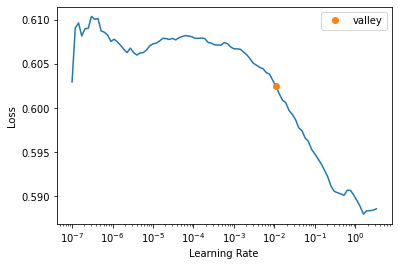

In [34]:
%%time
# Find the optimal Learning Rate for the model based on previous information...

learn.lr_find()

In [35]:
%%time
# Fit 3 epochs on the training dataset.
# Using the LR identified in the previous step.

lr = 0.023
learn.fit_one_cycle(10, lr_max = lr)

epoch,train_loss,valid_loss,accuracy,time
0,0.599150,0.576693,0.713750,00:00
1,0.586770,0.580737,0.714000,00:00
2,0.578588,0.569736,0.719000,00:00
3,0.573628,0.569252,0.718750,00:00
4,0.569958,0.574776,0.717500,00:00
5,0.566783,0.570857,0.717000,00:00
6,0.564471,0.574925,0.712250,00:00
7,0.562072,0.571937,0.718500,00:00
8,0.558998,0.572522,0.716250,00:00
9,0.555658,0.573496,0.713250,00:00


CPU times: user 3.06 s, sys: 84.1 ms, total: 3.14 s
Wall time: 3.18 s


In [36]:
%%time
#...
learn.fine_tune(50, base_lr = lr, freeze_epochs = 5)

epoch,train_loss,valid_loss,accuracy,time
0,0.547829,0.574676,0.717750,00:00
1,0.547101,0.577608,0.710250,00:00
2,0.549175,0.579485,0.716750,00:00
3,0.552091,0.580581,0.714750,00:00
4,0.553627,0.584453,0.683750,00:00


epoch,train_loss,valid_loss,accuracy,time
0,0.547661,0.576140,0.707250,00:00
1,0.543657,0.588750,0.700000,00:00
2,0.539612,0.586639,0.707750,00:00
3,0.536000,0.589429,0.706750,00:00
4,0.532843,0.588865,0.711500,00:00
5,0.529656,0.591065,0.706500,00:00
6,0.527083,0.593176,0.709250,00:00
7,0.525862,0.592546,0.707750,00:00
8,0.527022,0.592798,0.704000,00:00
9,0.526337,0.594772,0.707750,00:00


CPU times: user 17.5 s, sys: 439 ms, total: 18 s
Wall time: 19.6 s


---

## 8.0 Creating Predictions on the Test Set

In [37]:
%%time
#...
dl = learn.dls.test_dl(test_df)

CPU times: user 119 ms, sys: 140 ms, total: 259 ms
Wall time: 194 ms


In [38]:
%%time
#...
# dl.show_batch()

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 7.15 µs


In [39]:
%%time
#...
nn_predictions, _, preds = learn.get_preds(dl = dl, with_decoded = True)

CPU times: user 181 ms, sys: 7.13 ms, total: 188 ms
Wall time: 191 ms


In [40]:
%%time
#...
nn_predictions, preds

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.72 µs


(tensor([[0.7298, 0.2702],
         [0.2735, 0.7265],
         [0.7311, 0.2689],
         ...,
         [0.2816, 0.7184],
         [0.7308, 0.2692],
         [0.7310, 0.2690]]), tensor([0, 1, 0,  ..., 1, 0, 0]))

---

## 9.0 Creating the Submission File...

In [41]:
%%time
#...
submission.label = np.argmax(nn_predictions, axis = 1)

CPU times: user 2.59 ms, sys: 0 ns, total: 2.59 ms
Wall time: 15.3 ms


In [42]:
%%time
# Submit predicitons from the CV trained Model...
submission.to_csv('submission_fastai.csv', index = None)

CPU times: user 32.5 ms, sys: 2.86 ms, total: 35.3 ms
Wall time: 38.9 ms


In [43]:
%%time
# Submit predicitons from the CV trained Model...
submission.head()

CPU times: user 100 µs, sys: 5 µs, total: 105 µs
Wall time: 112 µs


,id,pred
0,20000,0.64071
1,20001,0.63690
2,20002,0.39250
3,20003,0.58866
4,20004,0.78360


---

# Classic Metod

In [44]:
%%capture

!pip install catboost
!pip install ipywidgets
!jupyter nbextension enable --py widgetsnbextension

In [45]:
models = {}

# Logistic Regression
from sklearn.linear_model import LogisticRegression
models['Logistic Regression'] = LogisticRegression()

# Support Vector Machines
from sklearn.svm import LinearSVC
models['Support Vector Machines'] = LinearSVC()

# Decision Trees
from sklearn.tree import DecisionTreeClassifier
models['Decision Trees'] = DecisionTreeClassifier(max_depth=7)

# Random Forest
from sklearn.ensemble import RandomForestClassifier
models['Random Forest'] = RandomForestClassifier(max_depth=7)

# Naive Bayes
from sklearn.naive_bayes import GaussianNB
models['Naive Bayes'] = GaussianNB()

# K-Nearest Neighbors
from sklearn.neighbors import KNeighborsClassifier
models['K-Nearest Neighbor'] = KNeighborsClassifier(n_neighbors=9)

import xgboost as xgb
models['XGB'] = xgb.XGBClassifier(
                                  tree_method="gpu_hist",
                                  enable_categorical=False,
                                  use_rmm = True
                                  )

from catboost import CatBoostClassifier, Pool
models['CatBoost'] = CatBoostClassifier(iterations=500,
                           task_type="GPU",
                           devices='0:1',
                           #cat_features = features_category,
                           verbose=False,
                           learning_rate=0.01)

In [46]:
from sklearn.model_selection import train_test_split

from sklearn.decomposition import PCA
from datetime import datetime

from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, plot_roc_curve
from sklearn import metrics

try:
  os.system('mkdir /content/output')
except:
  print('output folder already')

result = {}

X_train, X_test, y_train, y_test = train_test_split( train_df.drop(['id','label'], axis=1)
                                        , train_df['label']
                                        , test_size=0.25
                                        , random_state=42 )

X_submission = test_df[[x for x in train_df.columns if x not in ['label']]]\
                    .drop(['id'], axis=1)

for N in range(3,12):
  pca = PCA(n_components=N)
  X_train_PCA = pca.fit(X_train).transform(X_train)
  X_test_PCA = pca.transform(X_test)
  X_sub_PCA = pca.transform(X_submission)

  if N == 3:
    X_plot_PCA, y_plot = X_train_PCA, y_train

  accuracy, precision, recall, auc = {}, {}, {}, {}

  for key in models.keys():
    if key != 'XGB':
      # Fit the classifier
      models[key].fit(X_train_PCA, y_train)
      # Make predictions
      predictions = models[key].predict(X_test_PCA)
      try:
        proba = models[key].predict_proba(X_test_PCA)[:,1].reshape(-1,1)
      except:
        proba = predictions
      #plot_roc_curve(models[key], X_test_PCA, y_test) 
    else:
      models[key].fit(X_train_PCA, y_train)
      # Make predictions
      predictions = models[key].predict(X_test_PCA)
      proba = models[key].predict_proba(X_test_PCA)[:,1].reshape(-1,1)
      #plot_roc_curve(models[key], X_test_PCA, y_test) 

    # Calculate metrics
    accuracy[key] = accuracy_score(y_test, predictions)
    precision[key] = precision_score(y_test, predictions)
    recall[key] = recall_score(y_test, predictions)
    auc[key] = roc_auc_score(y_test, proba)

    #plt.show()

    key_desc = f"""{round(auc[key]*10000)/10000}_PCA{N}_{round(accuracy[key]*1000)/1000}_{round(precision[key]*1000)/1000}_{round(recall[key]*1000)/1000}_{key}"""
    try:
      submission.pred = models[key].predict_proba( X_sub_PCA )[:,1]
    except:
      submission.pred = models[key].predict( X_sub_PCA )
    submission.to_csv(f'/content/output/submission_{key_desc}.csv', index = None)

  # submission
  # os.system(f'kaggle competitions submit -c tabular-playground-series-nov-2022 -f submission_{key_desc}.csv -m "Message"')

  df_model = pd.DataFrame(index=[x for x in models.keys()],
                          columns=['AUC','Accuracy', 'Precision', 'Recall'])
  df_model['AUC'] = auc.values()
  df_model['Accuracy'] = accuracy.values()
  df_model['Precision'] = precision.values()
  df_model['Recall'] = recall.values()

  df_model = df_model.sort_values('Accuracy', ascending=False).reset_index()
  result[N] = df_model

  print( datetime.now()
        , N
        , '_'.join( [str(x) for x in df_model.iloc[0,:5].values] ) 
        )

2022-11-19 16:06:40.227256 3 XGB_0.7992616177558632_0.7192_0.7325581395348837_0.6847826086956522
2022-11-19 16:07:08.997375 4 XGB_0.7983864619094798_0.7188_0.7293617021276596_0.6900161030595813
2022-11-19 16:07:33.737162 5 XGB_0.7978056381189373_0.7172_0.7282423208191127_0.6871980676328503
2022-11-19 16:07:54.481908 6 XGB_0.7980136466389665_0.7182_0.7288207747977863_0.6892109500805152
2022-11-19 16:08:18.956400 7 XGB_0.7984371839870561_0.7174_0.7283582089552239_0.6876006441223832
2022-11-19 16:08:41.788313 8 CatBoost_0.8004387059693965_0.7186_0.7292464878671775_0.6896135265700483
2022-11-19 16:09:04.264588 9 CatBoost_0.8004643070180155_0.7188_0.7289719626168224_0.6908212560386473
2022-11-19 16:09:29.194679 10 XGB_0.7990559293308654_0.7194_0.7295116772823779_0.6916264090177133
2022-11-19 16:09:52.599873 11 XGB_0.7993281004789956_0.7192_0.7301790281329923_0.6896135265700483


In [47]:
df_model

,index,AUC,Accuracy,Precision,Recall
0,XGB,0.79933,0.71920,0.73018,0.68961
1,CatBoost,0.80087,0.71880,0.72800,0.69283
2,Logistic Regression,0.80314,0.71620,0.70793,0.72987
3,Support Vector Machines,0.71552,0.71540,0.70491,0.73470
4,Random Forest,0.79765,0.71480,0.74559,0.64654
5,Decision Trees,0.77617,0.69860,0.72795,0.62802
6,K-Nearest Neighbor,0.76754,0.69020,0.69342,0.67472
7,Naive Bayes,0.76404,0.67900,0.63713,0.82206


In [48]:
# # Drop all generated Submission_*.csv

# for f in [x for x in os.listdir('output/') if (('submission_' in x)&('.csv' in x))]:
#   os.system(f'rm "output/{f}"')

0 1


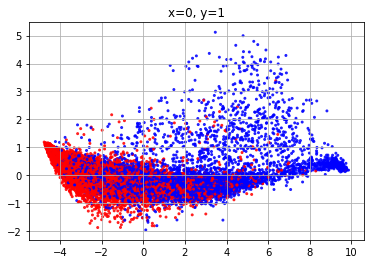

0 2


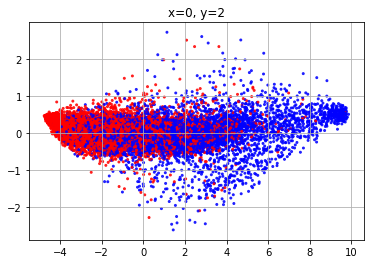

1 2


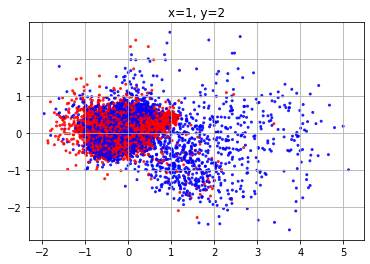

In [49]:
for i in range(X_plot_PCA.shape[1]):
  for j in range(X_plot_PCA.shape[1]):
    if (j>i):

      print(i,j)

      plt.figure()
      plt.title(f'x={i}, y={j}')
      plt.scatter(
            X_train_PCA[:,i],
            X_train_PCA[:,j],
            alpha=0.8,
            color=[str(x).replace('0','b').replace('1','r') for x in y_plot.values],
            s=4
      )
      plt.grid(True)
      plt.show()


In [50]:
!ls -l output

total 30400
-rw-r--r-- 1 root root 160008 Nov 19 16:06 'submission_0.7118_PCA3_0.712_0.696_0.746_Support Vector Machines.csv'
-rw-r--r-- 1 root root 160008 Nov 19 16:06 'submission_0.7126_PCA4_0.712_0.696_0.746_Support Vector Machines.csv'
-rw-r--r-- 1 root root 160008 Nov 19 16:08 'submission_0.7139_PCA8_0.714_0.702_0.737_Support Vector Machines.csv'
-rw-r--r-- 1 root root 160008 Nov 19 16:07 'submission_0.713_PCA5_0.713_0.696_0.748_Support Vector Machines.csv'
-rw-r--r-- 1 root root 160008 Nov 19 16:07 'submission_0.7142_PCA6_0.714_0.702_0.738_Support Vector Machines.csv'
-rw-r--r-- 1 root root 160008 Nov 19 16:08 'submission_0.7144_PCA9_0.714_0.702_0.738_Support Vector Machines.csv'
-rw-r--r-- 1 root root 160008 Nov 19 16:07 'submission_0.714_PCA7_0.714_0.701_0.738_Support Vector Machines.csv'
-rw-r--r-- 1 root root 160008 Nov 19 16:09 'submission_0.7151_PCA10_0.715_0.705_0.732_Support Vector Machines.csv'
-rw-r--r-- 1 root root 160008 Nov 19 16:09 'submission_0.7155_PCA11_0.715_0.7